# Generative art experiments

[Danielle Navarro](https://art.djnavarro.net/gallery/) gave a really cool talk on their generative art during the 2023 Ihaka lecture series.
I've loved making [games](https://avivajpeyi.itch.io/) for the past few years and one reason for that has been the ability to create something that is interactive and dynamic with code. I think generative art is a really cool way to explore that same idea! I'm going to try to make some generative art using python + matplotlib.


In [101]:
%matplotlib inline
import matplotlib.pyplot as plt


def hide_axes(ax):
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.set_xticklabels([])
    ax.set_yticklabels([])

## 1. Random walk

In [136]:
import matplotlib.pyplot as plt
import numpy as np


def next_step():
    direction = np.random.uniform(-1, 1, size=1)
    distance = np.random.normal(0, 5, size=1)
    return direction * distance


def generate_random_walk(n_steps, n_smooth):
    pts = np.zeros((2, n_steps))
    for i in range(1, n_steps):
        pts[0, i] = pts[0, i-1] + next_step()
        pts[1, i] = pts[1, i-1] + next_step()
    # smooth xy coordinates
    pts[0, :] = np.convolve(pts[0, :], np.ones(n_smooth)/n_smooth, mode='same')
    pts[1, :] = np.convolve(pts[1, :], np.ones(n_smooth)/n_smooth, mode='same')
    return pts


def plot_walk(n_steps, n_walkers, seed, colormap=plt.cm.Blues_r, alpha=0.5):
    n_smooth = int(n_steps * 0.05)
    np.random.seed(seed)
    plt.figure(figsize=(5,5), facecolor=(0, 0, 0))
    for i in range(n_walkers):
        pts = generate_random_walk(n_steps, n_smooth)[:, 0:n_steps-n_smooth]
        point_numbers = list(range(len(pts[0])))
        plt.scatter(pts[0, :], pts[1, :], c=point_numbers, cmap=colormap, edgecolors='none', s=1, alpha=alpha)

    plt.gca().set_facecolor('black')
    plt.axis('off')



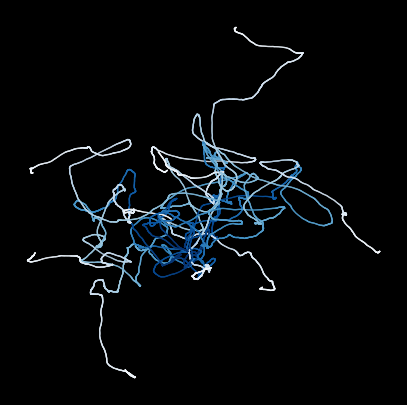

In [137]:
plot_walk(n_steps=5000, n_walkers=10, seed=0)

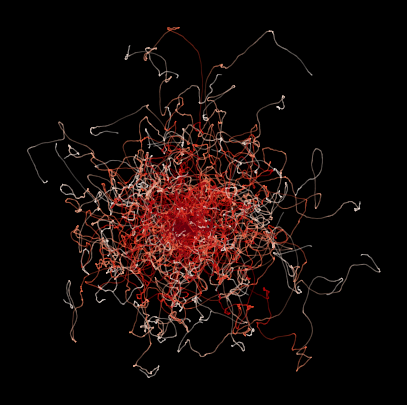

In [138]:
plot_walk(n_steps=5000, n_walkers=100, seed=1, colormap=plt.cm.Reds_r, alpha=0.05)

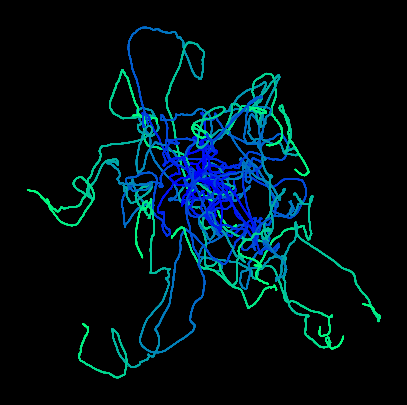

In [147]:
plot_walk(n_steps=100000, n_walkers=20, seed=2, colormap='winter', alpha=0.5)

## 2. N-body

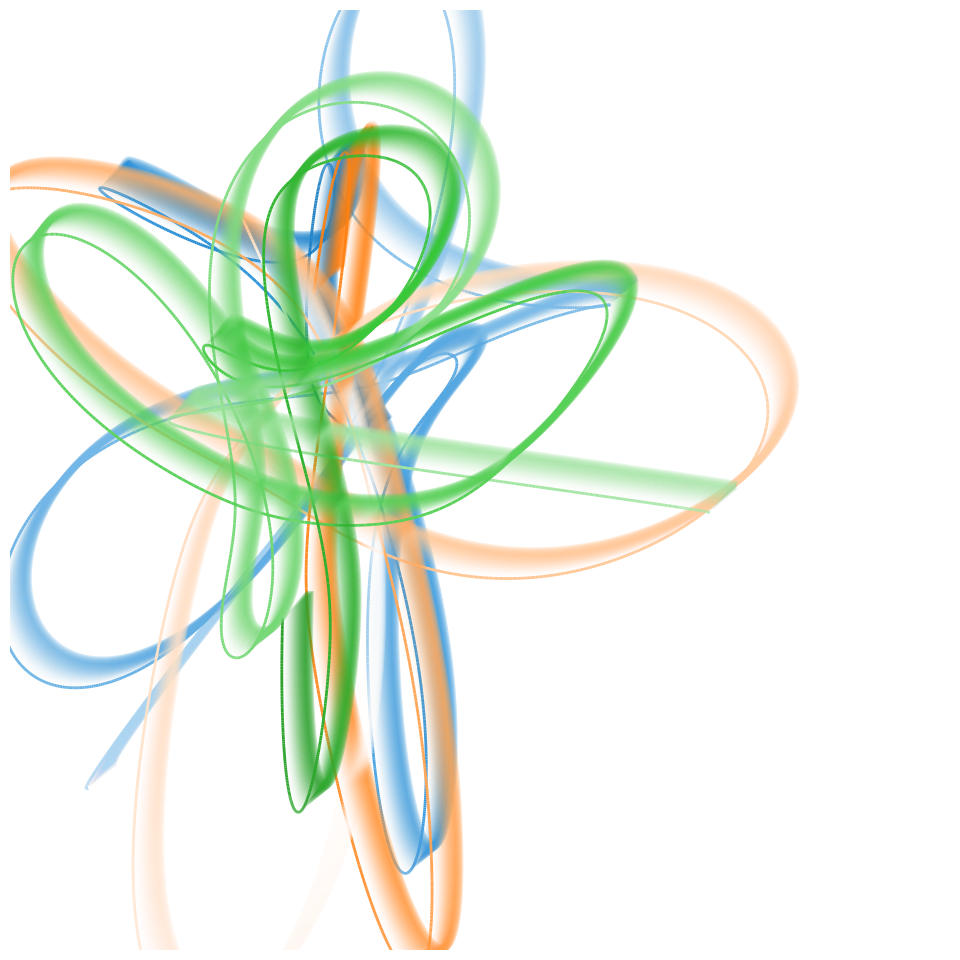

In [277]:
# Some utils
import matplotlib.pyplot as plt
import imageio
import os
import glob
import re
from datetime import datetime
import numpy as np
from tqdm.auto import trange, tqdm
import warnings

from matplotlib import rcParams

import colorsys
from matplotlib.colors import ColorConverter, LinearSegmentedColormap

rcParams.update({"xtick.major.pad": "7.0"})
rcParams.update({"xtick.major.size": "7.5"})
rcParams.update({"xtick.major.width": "1.5"})
rcParams.update({"xtick.minor.pad": "7.0"})
rcParams.update({"xtick.minor.size": "3.5"})
rcParams.update({"xtick.minor.width": "1.0"})
rcParams.update({"ytick.major.pad": "7.0"})
rcParams.update({"ytick.major.size": "7.5"})
rcParams.update({"ytick.major.width": "1.5"})
rcParams.update({"ytick.minor.pad": "7.0"})
rcParams.update({"ytick.minor.size": "3.5"})
rcParams.update({"ytick.minor.width": "1.0"})
rcParams.update({"font.size": 20})
rcParams.update({"xtick.top": True})
rcParams.update({"ytick.right": True})
rcParams.update({"xtick.direction": "in"})
rcParams.update({"ytick.direction": "in"})


def collect_runtimes(func, n_vals, n_trials=2, kwargs={}) -> np.ndarray:
    """
    Collect runtimes for a function with different input sizes

    Parameters
    ----------
    func : function
        Function to run
    n_vals : list
        List of input sizes
    n_trials : int, optional
        Number of trials to run, by default 2
    kwargs : dict, optional
        Keyword arguments to pass to func, by default {}

    Returns
    -------
    np.ndarray
        Array of runtimes with shape (len(n_vals), n_trials)
    """
    warnings.filterwarnings("error")
    runtimes = np.zeros((len(n_vals), n_trials))
    for npart_i in trange(len(n_vals), desc="Collecting runtimes"):
        for trial_i in range(n_trials):
            start = datetime.now()
            n = n_vals[npart_i]
            try:
                func(N=n, **kwargs)
                runtimes[npart_i, trial_i] = get_runtime(start)
            except RuntimeWarning:
                runtimes[npart_i, trial_i] = np.nan
    return runtimes


def get_runtime(start: datetime):
    return (datetime.now() - start).total_seconds()


def make_gif(im_regex, outname, duration=0.1):
    imgs = glob.glob(im_regex)
    imgs = sorted(imgs, key=lambda x: int(re.findall(r"\d+", x)[0]))
    frames = [imageio.imread_v2(f) for f in imgs]
    imageio.mimsave(outname, frames, duration=duration)
    for f in imgs:
        os.remove(f)


def remove_spines(ax):
    """Remove all spines and ticks from an axis"""
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])


def scale_color_brightness(color, scale_l=1.0):
    rgb = ColorConverter.to_rgb(color)
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s=s)


def make_colormap(color):
    rgb = [
        (i, scale_color_brightness(color, scale_l=i + 1)) for i in np.linspace(0, 1, 30)
    ]
    cmap = LinearSegmentedColormap.from_list(f"custom_{color}", colors=rgb, N=256)
    cmap = cmap.reversed()
    return cmap

from datetime import datetime
from tqdm.auto import trange
from typing import List, Union
import numpy as np
import matplotlib.pyplot as plt
import os
import random

G = 1.0  # Gravitational Constant
OUTDIR = 'orbit_out/'


### Basic Lists ###
def newtonian_acceleration_basic(pos, mass, G, softening):
    # positions r = [x,y,z] for all particles
    x = [p[0] for p in pos]
    y = [p[1] for p in pos]
    z = [p[2] for p in pos]

    # matrix that stores all pairwise particle separations: r_j - r_i
    dx = [[x[j] - x[i] for j in range(len(pos))] for i in range(len(pos))]
    dy = [[y[j] - y[i] for j in range(len(pos))] for i in range(len(pos))]
    dz = [[z[j] - z[i] for j in range(len(pos))] for i in range(len(pos))]

    # matrix that stores 1/r^3 for all particle pairwise particle separations
    inv_r3 = [
        [
            (dx[i][j] ** 2 + dy[i][j] ** 2 + dz[i][j] ** 2 + softening ** 2)
            for j in range(len(pos))
        ]
        for i in range(len(pos))
    ]
    for i in range(len(pos)):
        for j in range(len(pos)):
            if inv_r3[i][j] > 0:
                inv_r3[i][j] = inv_r3[i][j] ** (-1.5)

    ax = [G * sum(dx[i][j] * inv_r3[i][j] for j in range(len(pos))) * mass[i] for i in range(len(pos))]
    ay = [G * sum(dy[i][j] * inv_r3[i][j] for j in range(len(pos))) * mass[i] for i in range(len(pos))]
    az = [G * sum(dz[i][j] * inv_r3[i][j] for j in range(len(pos))) * mass[i] for i in range(len(pos))]

    # pack together the acceleration components
    a = [(ax[i], ay[i], az[i]) for i in range(len(pos))]

    return a


def nbody_runner_basic(
        N=5,
        tEnd=5.0,
        dt=0.01,
        softening=0.1,
        random_seed=17,
        max_runtime=5,
        verbose=True,
):
    """ N-body simulation """

    random.seed(random_seed)
    # Initialisation
    mass = [20.0 / N] * N  # total mass of particles is 20
    pos = [[random.random() for _ in range(3)] for _ in range(N)]  # randomly selected positions and velocities
    vel = [[random.random() for _ in range(3)] for _ in range(N)]
    t = 0
    Nt = int(np.ceil(tEnd / dt))
    runtime_start = datetime.now()
    vel_mean = [sum(m * v for m, v in zip(mass, v)) / sum(mass) for v in zip(*vel)]
    vel = [[v[i] - vel_mean[i] for i in range(3)] for v in vel]
    acc = newtonian_acceleration_basic(pos, mass, G, softening)
    pos_save = [[[0.0 for _ in range(3)] for _ in range(N)] for _ in range(Nt + 1)]
    for i in range(N):
        for j in range(3):
            pos_save[i][j][0] = pos[i][j]

    # Simulation loop
    for i in trange(Nt, disable=not verbose, desc="Running simulation"):
        vel = [[v[j] + acc[i][j] * dt / 2.0 for j in range(3)] for i, v in enumerate(vel)]
        pos = [[pos[i][j] + vel[i][j] * dt for j in range(3)] for i in range(N)]
        acc = newtonian_acceleration_basic(pos, mass, G, softening)
        vel = [[v[j] + acc[i][j] * dt / 2.0 for j in range(3)] for i, v in enumerate(vel)]
        t += dt
        for k in range(N):
            for j in range(3):
                pos_save[i][k][j] = pos[k][j]
        runtime = get_runtime(runtime_start)
        if runtime > max_runtime:
            warnings.warn(f"Runtime exceeded {max_runtime} seconds. Stopping simulation.")
            break

    pos_save = np.array(pos_save)
    pos_save = np.transpose(pos_save, (1, 2, 0))
    return pos_save


def plot_particles(positions: Union[List, np.ndarray], n_time_total: int = 0, color='tab:blue'):
    """Plot the positions of particles in 2D

    Parameters
    ----------
    positions : Union[List, np.ndarray]
        List of positions of particles. Should be of shape (n_particles, {xyz}, n_time).
    n_time_total : int, optional
        Total number of time steps (used for plotting the trail), by default 0
    color : str, optional
        Color of the particles, by default 'tab:blue'
    """

    n_part, _, n_time = positions.shape
    if n_time_total == 0:
        n_time_total = n_time

    fig = plt.figure(figsize=(4, 4), dpi=80)
    ax = fig.gca()

    # plot the particle orbits
    idx_end = np.argmax(np.where(np.sum(positions, axis=(0, 1)) != 0)[0])
    idx_start = np.max([int(idx_end - 0.1 * n_time_total), 0])
    nidx = idx_end - idx_start

    max_size = 10
    ax.scatter(
        positions[:, 0, idx_end], positions[:, 1, idx_end],
        s=max_size, color=color, ec='k', lw=0.5
    )

    # plot the trail
    if nidx > 1:
        ms = np.geomspace(1e-4, max_size, nidx)
        # set ms < 0.05 to 0
        mask = ms < 0.05
        ms[mask] = 0

        # colors = np.array([make_colormap('tab:blue', 'white')(i) for i in np.linspace(0, 1, nidx)])
        ax.scatter(
            positions[:, 0, idx_start:idx_end], positions[:, 1, idx_start:idx_end],
            s=[ms] * n_part, zorder=-10,
            c=[ms] * n_part,
            cmap=make_colormap(color),

        )

    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax = plt.gca()
    remove_spines(ax)
    ax.set_aspect('equal', 'box')
    # remove white border around figure
    fig.tight_layout(pad=0)
    return fig


def plot_particle_gif(pos, outdir, dur):
    os.makedirs(outdir, exist_ok=True)
    n_part, _, n_time = pos.shape
    for i in trange(10, n_time, 10, desc='Making gif'):
        fig = plot_particles(pos[:, :, 0:i], n_time_total=n_time, color='tab:blue')
        # add textbox in top left corner
        ax = plt.gca()
        ax.text(
            0.05, 0.95,
            f't={i:003d}', transform=ax.transAxes,
            fontsize=14, verticalalignment='top',
            fontstyle='italic',
            alpha=0.5,
        )
        fig.savefig(f'{outdir}/orbit_{i:003d}.png')
        plt.close(fig)
    make_gif(f'{outdir}/orbit_*.png', f'{outdir}/orbit.gif', duration=dur)
    print(f'Gif saved to {outdir}/orbit.gif')


def newtonian_acceleration_np(pos, mass, G, softening):
    # positions r = [x,y,z] for all particles
    x = pos[:, 0:1]
    y = pos[:, 1:2]
    z = pos[:, 2:3]

    # matrix that stores all pairwise particle separations: r_j - r_i
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    # matrix that stores 1/r^3 for all particle pairwise particle separations
    inv_r3 = (dx ** 2 + dy ** 2 + dz ** 2 + softening ** 2)
    inv_r3[inv_r3 > 0] = inv_r3[inv_r3 > 0] ** (-1.5)

    # pack together the acceleration components
    return G * np.hstack((
        np.matmul(dx * inv_r3, mass),
        np.matmul(dy * inv_r3, mass),
        np.matmul(dz * inv_r3, mass)
    ))


def nbody_runner_np(
        N: int = 5,
        tEnd: float = 10.0,
        dt: float = 0.01,
        softening: float = 0.1,
        random_seed: int = 17,
        max_runtime: int = 5,
        verbose: bool = True,
):
    """ N-body simulation """

    # Initialisation
    np.random.seed(random_seed)
    mass = 20.0 * np.ones((N, 1)) / N  # total mass of particles is 20
    pos = np.random.randn(N, 3)  # randomly selected positions and velocities
    vel = np.random.randn(N, 3)
    t = 0
    Nt = int(np.ceil(tEnd / dt))
    runtime_start = datetime.now()
    vel -= np.mean(mass * vel, 0) / np.mean(mass)
    acc = newtonian_acceleration_np(pos, mass, G, softening)
    pos_save = np.zeros((N, 3, Nt + 1))
    pos_save[:, :, 0] = pos

    # Simulation loop
    for i in trange(Nt, desc="Running simulation", disable=not verbose):
        vel += acc * dt / 2.0
        pos += vel * dt
        acc = newtonian_acceleration_np(pos, mass, G, softening)
        vel += acc * dt / 2.0
        t += dt
        pos_save[:, :, i + 1] = pos
        runtime = get_runtime(runtime_start)
        if runtime > max_runtime:
            warnings.warn(f"Runtime exceeded {max_runtime} seconds. Stopping simulation.")
            break
    return pos_save




import matplotlib.collections as mcoll

def colorline(
    x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(lc)

    return lc


def make_segments(x, y):
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments



def plot_simple_orbits(seed):
    plt.figure(figsize=(10,10))
    positions = nbody_runner_basic(N=3, random_seed=seed, tEnd=2, verbose=False, dt=0.001)

    pts = np.linspace(0, 1, positions.shape[2])
    for i, plnts in enumerate(positions):
        # decrease alpha over time
        # alpha = np.linspace(0.1, 1, len(i))
        # color between white and blue
        colorbar = make_colormap(f'C{i}')

        colorline(plnts[0][1:-1], plnts[1][1:-1], pts, cmap=colorbar, linewidth=2)

        for _ in reversed(range(30)):
            colorline(plnts[0][1:-1]+0.001*_, plnts[1][1:-1]+0.001*_, pts, cmap=colorbar, linewidth=2*0.1*_, alpha=0.01*_)

    # turn off axis
    # plt.suptitle(seed)
    plt.axis('off')
    plt.tight_layout()


seed = 91
# positions = nbody_runner_basic(N=3, random_seed=seed, tEnd=15, verbose=False)
# plot_particle_gif(positions, outdir=f'orbits.gif', dur=3)
plot_simple_orbits(91)

![](orbits.gif/orbit.gif)

## 3. Math functions

In [240]:
! pip install samila==1.1 -q


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3.11 -m pip install --upgrade pip


/var/folders/qt/rxjvm_j566v9qn7g754s1v9hzb3p7f/T/ipykernel_54423/367560737.py:13: RuntimeWarning: invalid value encountered in sqrt
  result = random.uniform(-0.5,0.5) * y**3 - np.cos(x**2) + np.sqrt(2*x)


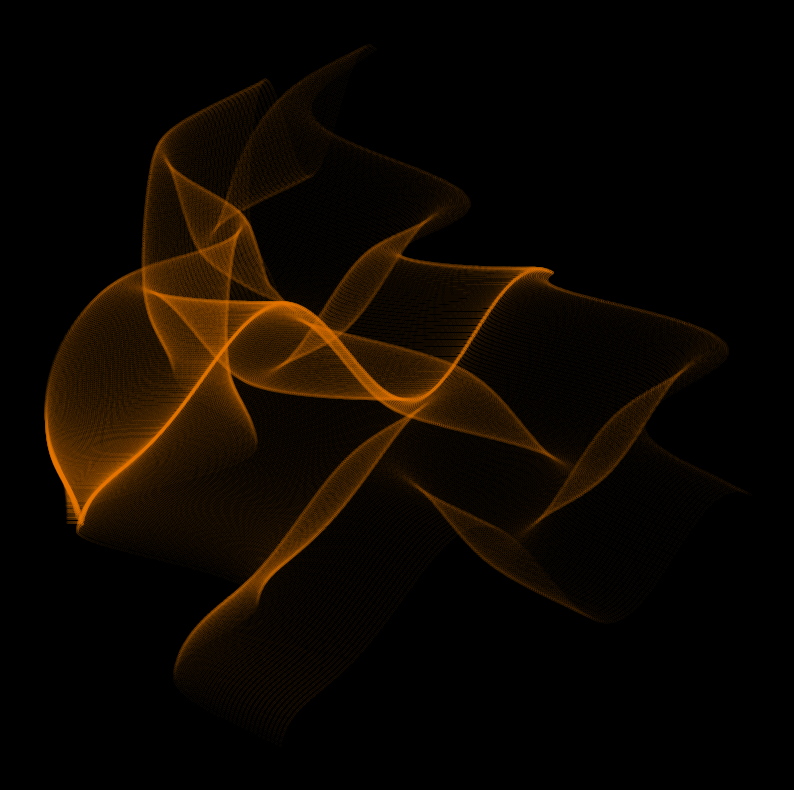

In [260]:
import matplotlib.pyplot as plt
import random
from samila import GenerativeImage, Projection, Marker
from samila import Projection

np.random.seed(0)

def f1(x, y):
    result = random.uniform(-1,1) * x**2  - np.sin(y**2) + np.abs(y-x)
    return result

def f2(x, y):
    result = random.uniform(-0.5,0.5) * y**3 - np.cos(x**2) + np.sqrt(2*x)
    return result

def f3(x, y):
    result = random.uniform(-1,1) * x*y + np.tan(x*y)
    return result

# g2 = GenerativeImage(f2, f1)
# g2.generate(seed=0)
# g2.plot(cmap="winter", color="darkblue", projection="HAMMER", rotation=45, bgcolor="transparent")

g2 = GenerativeImage(f2, f1)
g2.generate(seed=5)
g2.plot(cmap="winter", color="darkorange", alpha=0.5, bgcolor="black",)
plt.show()

/var/folders/qt/rxjvm_j566v9qn7g754s1v9hzb3p7f/T/ipykernel_54423/3859948697.py:13: RuntimeWarning: invalid value encountered in sqrt
  result = random.uniform(-0.5,0.5) * y**3 - np.cos(x**2) + np.sqrt(2*x)


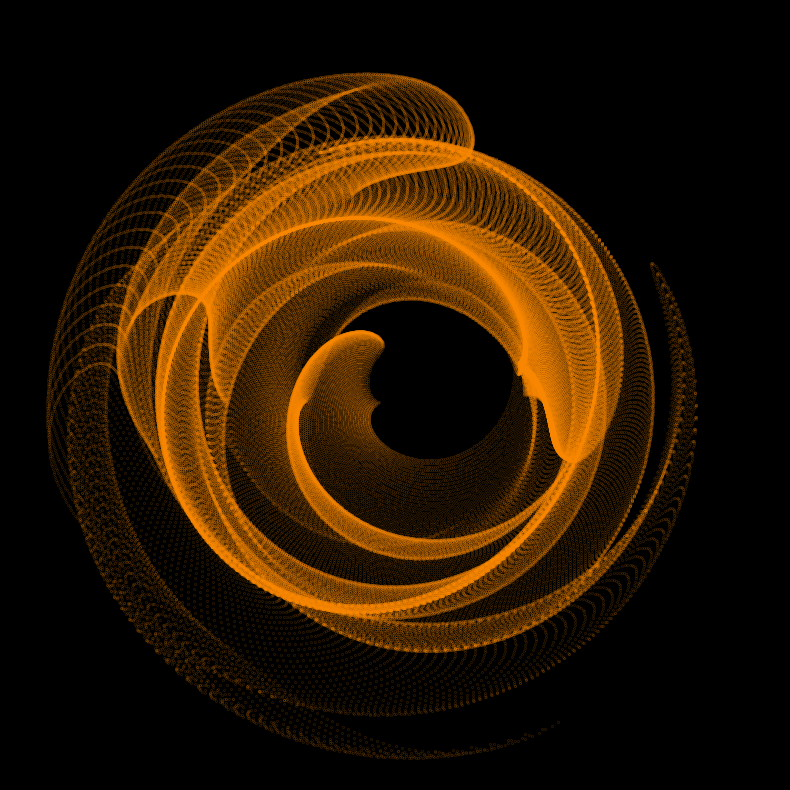

In [258]:
from samila import Marker
g2.generate(seed=5)
g2.plot(cmap="winter", color="darkorange", projection=Projection.POLAR, marker=Marker.CIRCLE,alpha=1,bgcolor="black")
plt.show()